In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns; sns.set()
import psycopg2, re, os, WebScraping

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

# Make connection to database
connection = psycopg2.connect(
    user = "athanar",
    host = "localhost",
    port = "5432",
    database = "datascience")
cursor = connection.cursor()

In [3]:
def queryfile(filename):
    # Read SQL file
    fd = open(filename, 'r')
    sqlFile = fd.read()
    fd.close()
    sqlCommands = sqlFile.split(';')
    retval = []
    for command in sqlCommands:
        try:
            cursor.execute(command)
            retval.append(pd.DataFrame(cursor.fetchall()))
        except:
            continue
    return retval

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def clean(s):
    s = re.sub("[a-z](\d+)|(\d+)[a-z]", '', s)
    s = re.sub(r'[a-z]([^\x00-\x7F]+)|([^\x00-\x7F]+)[a-z]','', s)
    s = re.sub(r'\d+-\d+-\d+|\d+\/\d+\/\d+','<DATE>', s)
    s = re.sub(r'http\S+', '<url>', s)
    s = s.lower().replace('\n\n', '')
    s = re.sub(r'([\x21-\x2f\x3a-\x60\x7b-\x7e])', r' \1', s)
    s = re.sub(r'[\u2000-\u2027\x80-\xff]', '', s)
    s = re.sub(' +', ' ', s)
    s = s.strip()
    return s

In [4]:
# Scrapes a subset of articles from the politics and conflicts section on wikinews. 
webscrapes = WebScraping.retSoup()

Scraping articles from: https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&from=F
Scraping articles from: https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&pagefrom=Former+Managing+Director+of+Gambian+newspaper+appears+in+court&subcatfrom=F&filefrom=F#mw-pages
Scraping articles from: https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&pagefrom=Gaddafi+loyalists+allegedly+using+Red+Cross+helicopters+to+bomb+rebel+held+city&subcatfrom=F&filefrom=F#mw-pages
Scraping articles from: https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&pagefrom=Gujarat+high+court+refutes+Modi%27s+objection+to+Lokyukta%27s+appointment&subcatfrom=F&filefrom=F#mw-pages
Scraping articles from: https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&pagefrom=Illinois+Governor+Blagojevich+appoints+Roland+Burris+for+vacated+U.S.+Senate+seat&subcatfrom=F&filefrom=F#mw-pages
Scraping articles from: https://en.w

[Text(0, 0.5, 'Probability'), Text(0.5, 0, 'String length')]

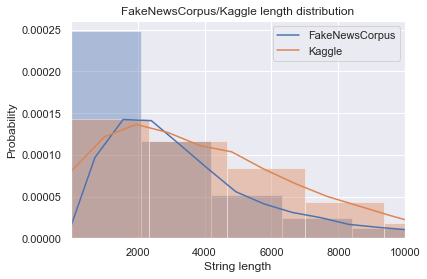

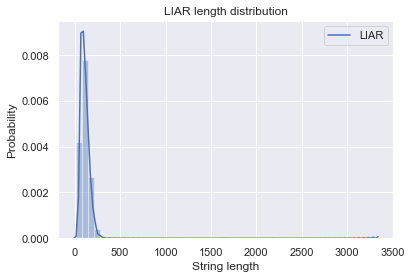

In [7]:
# load all three datasets
testFile = 'train.tsv'
kagglefile = 'test_set.json'

scraped_data = pd.DataFrame({'statement':webscrapes.content, 'label' : [8 for i in range(len(webscrapes.content))]})

corpusdata = queryfile('corpusquery.sql')
traindata = pd.concat([corpusdata[i] for i in range(len(corpusdata))])
traindata.columns = ['statement', 'label']
traindata = pd.concat([traindata, scraped_data])

testdata = pd.read_csv(testFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los"])

testdata_kaggle = pd.read_json(kagglefile)
testdata_kaggle = testdata_kaggle.rename(columns={'article':'statement'})

traindata.label = traindata.label.apply(lambda x: 1 if(x == 8 or x == 5 or x == 10) else 0)
testdata.label = testdata.label.apply(lambda x: 1 if(x == 'true' or x == 'mostly-true' or x == 'half-true') else 0)

traindata.statement = traindata.statement.apply(clean)
testdata.statement = testdata.statement.apply(clean)
testdata_kaggle.statement = testdata_kaggle.statement.apply(clean)

fig, ax = plt.subplots()
sns.distplot(traindata.statement.str.len(), ax=ax, kde_kws={"label": "FakeNewsCorpus"})

sns.distplot(testdata_kaggle.statement.str.len(), ax=ax,kde_kws={"label": "Kaggle"}).set_title('FakeNewsCorpus/Kaggle length distribution')
ax.set_xlim(1,10000)
ax.set(xlabel='String length', ylabel='Probability')
fig2, ax2 = plt.subplots()
sns.distplot(testdata.statement.str.len(), ax=ax2,kde_kws={"label": "LIAR"}).set_title('LIAR length distribution')
ax2.set(xlabel='String length', ylabel='Probability')

#  Baseline

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english")
vectorizer.fit(traindata.statement.values)

X_train = vectorizer.transform(traindata.statement.values)
X_test = vectorizer.transform(testdata.statement.values)
y_train = traindata.label.values
y_test = testdata.label.values

logreg = LogisticRegression()
score = cross_val_score(logreg, X_train, y_train, cv=5)


svc = LinearSVC(tol=1e-05)
score_svc = cross_val_score(svc, X_train, y_train, cv=5)


neigh = KNeighborsClassifier(n_neighbors=3)
scoreknn = cross_val_score(neigh, X_train, y_train, cv=5)


rfc = RandomForestClassifier(max_depth=2, random_state=0)
scorerfc = cross_val_score(rfc, X_train, y_train, cv=5)

logreg.fit(X_train, y_train)
svc.fit(X_train, y_train)
neigh.fit(X_train, y_train)
rfc.fit(X_train, y_train)

kaggle_pred = logreg.predict(vectorizer.transform(testdata_kaggle.statement.values))
print(kaggle_pred)
preds = pd.DataFrame({'label':pd.Series(kaggle_pred)})
preds.label = preds.label.apply(lambda x: 'REAL' if(x == 1) else 'FAKE')
preds['id'] = testdata_kaggle['id']
preds.id = preds.id.astype(str).astype(int)
preds.to_csv('kaggle_sub.csv', index=False)


score_LIAR_logreg = logreg.score(X_test, y_test)
score_LIAR_svc = svc.score(X_test, y_test)
score_LIAR_knn = neigh.score(X_test, y_test)
score_LIAR_rfc = rfc.score(X_test, y_test)

print("LogReg accuracy:", score.mean())
print("LogReg_LIAR accuracy:", score_LIAR_logreg)

print("LinearSVC accuracy", score_svc.mean())
print("LinearSVC_LIAR accuracy", score_LIAR_svc)

print("kNN accuracy", scoreknn.mean())
print("kNN_LIAR accuracy", score_LIAR_knn)

print("RandomForest Accuracy:", scorerfc.mean())
print("RandomForest_LIAR Accuracy:", score_LIAR_rfc)


In [ ]:
def gridsearch():
    pipeline = Pipeline([
        ('vect', TfidfVectorizer()),
        ('clf', LogisticRegression()),
    ])
    params = [{
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__min_df' : (1, 2),
        'vect__max_features': (None, 5000, 10000),
        'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
        'vect__stop_words': ("english", None),
        'clf__penalty' : ['l1', 'l2'],
    }]

    grid_search = GridSearchCV(pipeline, params, n_jobs=8, verbose=1)
    grid_search.fit(traindata.statement.values, traindata.label)
    best_parameters = grid_search.best_estimator_.get_params()
    score = grid_search.score(testdata.statement.values, testdata.label)
    print("GridSearch score: ", score)
gridsearch()

# Advanced

-Model construction
-Model fit and evaluate
-Model plot and prediction -> .csv

In [21]:
X_1, X_2, y_1, y_2 = train_test_split(traindata.statement.values, traindata.label.values
                                                    , test_size=0.33, random_state=42)

X_1 = vectorizer.transform(X_1)
X_2 = vectorizer.transform(X_2)
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                2475350   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 2,475,361
Trainable params: 2,475,361
Non-trainable params: 0
_________________________________________________________________


In [22]:

history = model.fit(X_1, y_1,
                   epochs=100,
                   verbose=1,
                   validation_data=(X_2, y_2),
                   batch_size=100,
                   workers=10)
loss, accuracy = model.evaluate(X_1, y_1, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_2, y_2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 32696 samples, validate on 16104 samples
Epoch 1/100
32696/32696 [==============================] - 89s 3ms/step - loss: 0.4840 - accuracy: 0.7910 - val_loss: 0.3483 - val_accuracy: 0.8625
Epoch 2/100
32696/32696 [==============================] - 89s 3ms/step - loss: 0.2630 - accuracy: 0.9127 - val_loss: 0.2652 - val_accuracy: 0.8915
Epoch 3/100
32696/32696 [==============================] - 88s 3ms/step - loss: 0.1702 - accuracy: 0.9513 - val_loss: 0.2323 - val_accuracy: 0.9005
Epoch 4/100
32696/32696 [==============================] - 89s 3ms/step - loss: 0.1139 - accuracy: 0.9739 - val_loss: 0.2159 - val_accuracy: 0.9054
Epoch 5/100
32696/32696 [==============================] - 90s 3ms/step - loss: 0.0768 - accuracy: 0.9864 - val_loss: 0.2093 - val_accuracy: 0.9069
Epoch 6/100
32696/32696 [==============================] - 87s 3ms/step - loss: 0.0522 - accuracy: 0.9937 - val_loss: 0.2084 - val_accuracy: 0.9064
Epoch 7/100
32696/32696 [==============================] - 93s

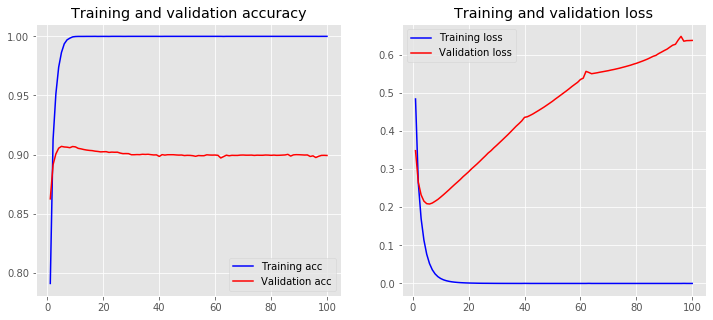

In [24]:
plot_history(history)
#Xnew_test = vectorizer.transform(testdata1.statement.values)
#prediction = model.predict_classes(Xnew_test)
#new_pred = [item for sublist in prediction for item in sublist]
#preds = pd.DataFrame({'label':pd.Series(new_pred)})
#preds.label = preds.label.apply(lambda x: 'REAL' if(x == 1) else 'FAKE')
#preds['id'] = testdata1['id']
#preds.id = preds.id.astype(str).astype(int)
#preds.to_csv('kaggle_sub.csv', index=False)

# Convolutional network

In [37]:
X_3, X_4, y_3, y_4 = train_test_split(traindata.statement.values, traindata.label.values
                                                    , test_size=0.33, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_3)

X_3 = tokenizer.texts_to_sequences(X_3)
X_4 = tokenizer.texts_to_sequences(X_4)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_3 = pad_sequences(Xt_train, padding='post', maxlen=maxlen)
X_4 = pad_sequences(Xt_test, padding='post', maxlen=maxlen)

In [38]:
embedding_dim = 100


model_conv = Sequential()
model_conv.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_conv.add(layers.Conv1D(128, 5, activation='relu'))
model_conv.add(layers.GlobalMaxPooling1D())
model_conv.add(layers.Dense(10, activation='relu'))
model_conv.add(layers.Dense(1, activation='sigmoid'))
model_conv.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_conv.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          19816900  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 19,882,329
Trainable params: 19,882,329
Non-trainable params: 0
_________________________________________________________________


In [42]:
history_conv = model_conv.fit(X_3, y_3,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_4, y_4),
                    batch_size=100,
                    workers=8)
loss, accuracy = model_conv.evaluate(X_3, y_3, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_conv.evaluate(X_4, y_4, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 32696 samples, validate on 16104 samples
Epoch 1/20
32696/32696 [==============================] - 96s 3ms/step - loss: 1.8145e-04 - accuracy: 1.0000 - val_loss: 0.6891 - val_accuracy: 0.8738
Epoch 2/20
32696/32696 [==============================] - 95s 3ms/step - loss: 1.9986e-04 - accuracy: 1.0000 - val_loss: 0.7089 - val_accuracy: 0.8741
Epoch 3/20
32696/32696 [==============================] - 96s 3ms/step - loss: 2.1181e-04 - accuracy: 0.9999 - val_loss: 0.7214 - val_accuracy: 0.8736
Epoch 4/20
32696/32696 [==============================] - 95s 3ms/step - loss: 1.8913e-04 - accuracy: 1.0000 - val_loss: 0.7387 - val_accuracy: 0.8733
Epoch 5/20
32696/32696 [==============================] - 95s 3ms/step - loss: 1.7596e-04 - accuracy: 1.0000 - val_loss: 0.7547 - val_accuracy: 0.8736
Epoch 6/20
32696/32696 [==============================] - 95s 3ms/step - loss: 1.6927e-04 - accuracy: 1.0000 - val_loss: 0.7709 - val_accuracy: 0.8735
Epoch 7/20
32696/32696 [====================

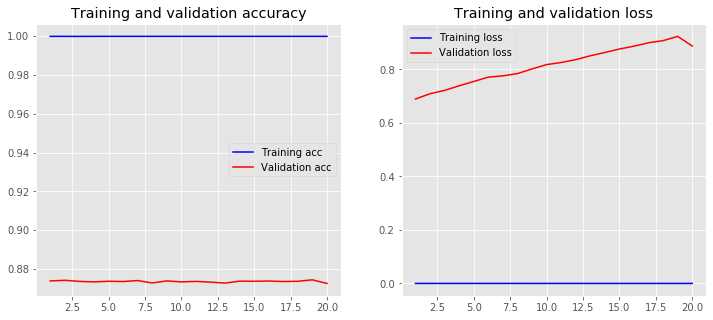

In [43]:
plot_history(history_conv)
#new_preds = modelt.predict(Xfinal_test)
#print(new_preds.shape, sum(new_preds))